# This is a visualization of usage over time fo the Toronto Bike data available through Open Data from the City of Toronto

## Historical data can be found: https://open.toronto.ca/dataset/bike-share-toronto-ridership-data/

In [26]:
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt

url_pkg = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "7e876c24-177c-4605-9cef-e50dd74c617f"}
pkg = "7e876c24-177c-4605-9cef-e50dd74c617f"
package = requests.get(url_pkg, params = params).json()


#print the available files, their format, size, and ID
print("Available Datasets\n")
print("name\t", "format\t\t", "size\t\t", "ID")
print("----------------------------------------------------------------------------------")
# for d in (package["result"]['resources']):
#     print(d['name'], d["format"], d['size'],d['id'])
data_list = [ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

#Accessing of dataset Bike share ridership 2021-01
url = package["result"]['resources'][8]['url']
data = requests.get(url).content
decoded_data = data.decode("ISO-8859-1")
d = pd.read_csv(io.StringIO(decoded_data), sep = ",")
l = d.shape[0]
#Append all data for 2021
for i in data_list:
    url = package["result"]['resources'][i]['url']
    data = requests.get(url).content
    decoded_data = data.decode("ISO-8859-1")
    t = pd.read_csv(io.StringIO(decoded_data), sep = ",",
                    names = ['Trip Id', 'Trip  Duration', 'Start Station Id', 'Start Time',
                               'Start Station Name', 'End Station Id', 'End Time', 'End Station Name',
                               'Bike Id', 'User Type'],
                    skiprows = 1)
    #t.columns = ['Trip Id', 'Trip  Duration', 'Start Station Id', 'Start Time',
    #                           'Start Station Name', 'End Station Id', 'End Time', 'End Station Name',
    #                           'Bike Id', 'User Type']
    l += t.shape[0]
    d = pd.concat([d, t], ignore_index=True)
    
#Print column names
print("\nData dataframe columns\n",list(d.columns))
N_trips_raw = d.shape[0]
print(d.shape, l)


Available Datasets

name	 format		 size		 ID
----------------------------------------------------------------------------------

Data dataframe columns
 ['Trip Id', 'Trip  Duration', 'Start Station Id', 'Start Time', 'Start Station Name', 'End Station Id', 'End Time', 'End Station Name', 'Bike Id', 'User Type']
(3575182, 10) 3575182


In [27]:
#Convert to datetime and add column called "Length" for duration of trip
d['Start Time'] = pd.to_datetime(d['Start Time'], format = "%m/%d/%Y %H:%M")
d['End Time'] = pd.to_datetime(d['End Time'], format = "%m/%d/%Y %H:%M")

### Check data then clean

#### Let's assume aything shorter than a minute is not and actual 'use' of the bike, and that we want day trips/commutes -- not trips longer than 6 hours. We could use interquartile range to identify outliers but because we have a good intuition about wht the data 'should' look like, we can simply slice it.

In [31]:
#take only data longer than a minute and shorter than a day
print("Number of trips shorter than a minute: ",(d["Trip  Duration"]< 60).sum(), "\tPercent of total: ", ((d["Trip  Duration"]< 60).sum())/N_trips_raw)
print("Number of trips longer than 6 hours: ",(d["Trip  Duration"] > 60*60*6).sum(), "\tPercent of total: ", ((d["Trip  Duration"]> 60*60*24).sum())/N_trips_raw)


d = d[d["Trip  Duration"].between(60, 60*60*6)]
N_trips = d.shape[0]#find new number of trips
print("Origional trip number: ", N_trips_raw, "\nNumber of trips longer than one minute and shorter than one day: ", N_trips,
     "\nPercent of trips retained: ", (N_trips)/N_trips_raw*100 )

Number of trips shorter than a minute:  0 	Percent of total:  0.0
Number of trips longer than 6 hours:  2812 	Percent of total:  0.0
Origional trip number:  3575182 
Number of trips longer than one minute and shorter than one day:  3560489 
Percent of trips retained:  99.58902791522222


#### Define simple numerical data histogram plotting function to help clean data

In [33]:
def HistPlot(data, text_size, ylabel, xlabel, title, xticks, xrot, **kwargs):
    fig, ax = plt.subplots()
    data.plot(**kwargs, fontsize = text_size, ax = ax)
    ax.set_xlabel(xlabel, size = text_size)
    ax.set_ylabel(ylabel, size = text_size)
    ax.set_title(title, size = text_size+2)
    if xticks != False:
        ax.set_xticklabels(xticks)
    plt.xticks(rotation=xrot)

    return()


Plot a histograms of trip duration, and number of trips per weekday and month to get a sense of the data

()

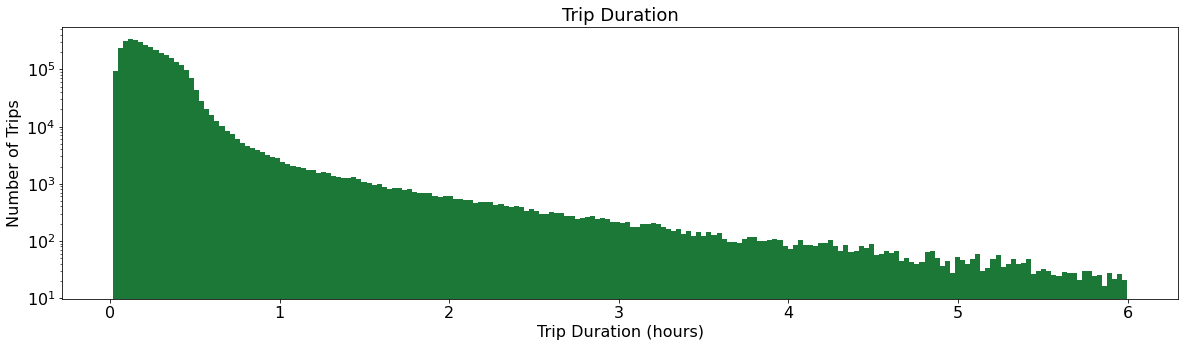

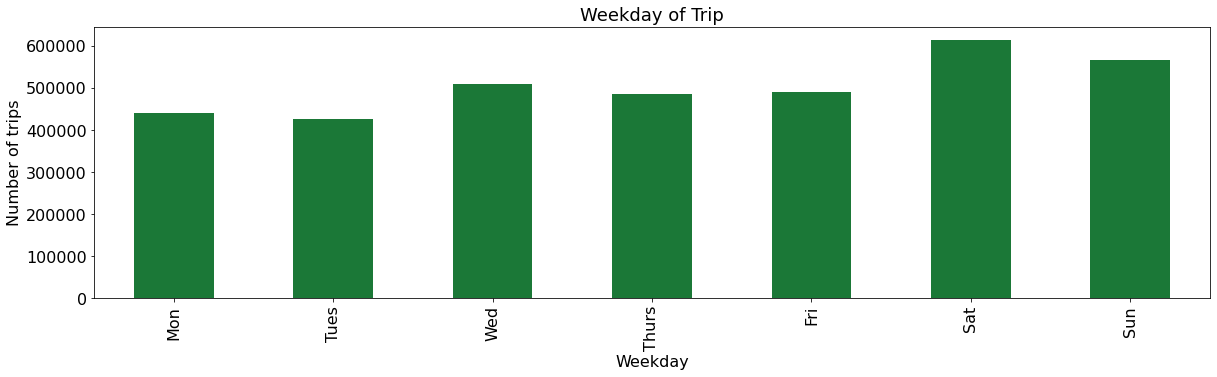

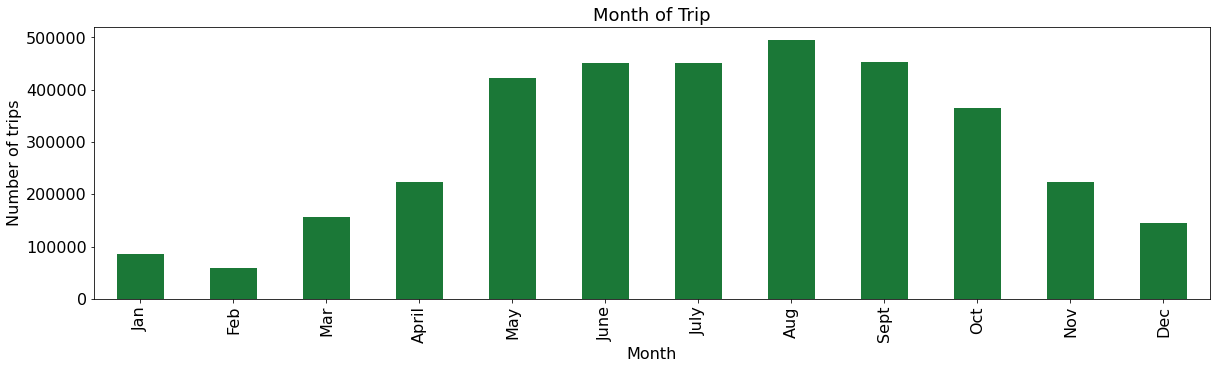

In [45]:
#Plot duration histrogram (maybe someone stole a bike....)
HistPlot(d['Trip  Duration']/(3600), 16, "Number of Trips", "Trip Duration (hours)","Trip Duration", False, 0, kind = "hist", bins = 200, color = "#1b7837", figsize = (20,5), logy = True)

#Plot start time
df = d.groupby(d["Start Time"].dt.weekday).size().reset_index()
df.columns = ["Weekday", 'count']
xticks = ["Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"]
HistPlot(df, 16, "Number of trips", "Weekday", "Weekday of Trip",xticks, 90, kind = "bar", x="Weekday", y = "count", color = "#1b7837", figsize = (20,5), legend = False)

#Plot start time
df = d.groupby(d["Start Time"].dt.month).size().reset_index()
df.columns = ["Month", 'count']
xticks = ["Jan", "Feb", "Mar","April", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]
HistPlot(df, 16, "Number of trips", "Month", "Month of Trip",xticks, 90, kind = "bar", x="Month", y = "count", color = "#1b7837", figsize = (20,5), legend = False)


Double check that the times are all the same timezone. Data files are by month, so an easy way is to plot the start time of trips per month and see if there are obvious discrepancies.

In [46]:
fig, ax = plt.subplots(figsize=(8,6))
d.groupby(d["Start Time"].dt.month).plot(kind='hist', ax=ax)
print('done')

ValueError: view limit minimum -537436.8200000001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -537436.8200000001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

()

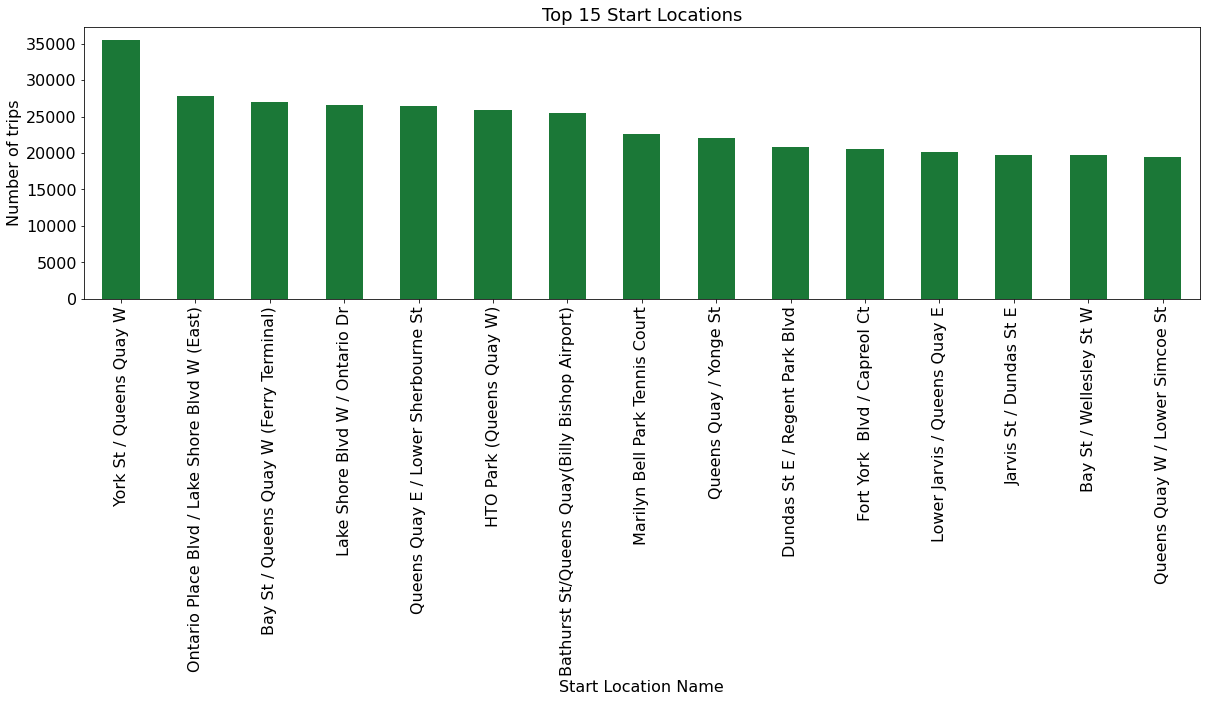

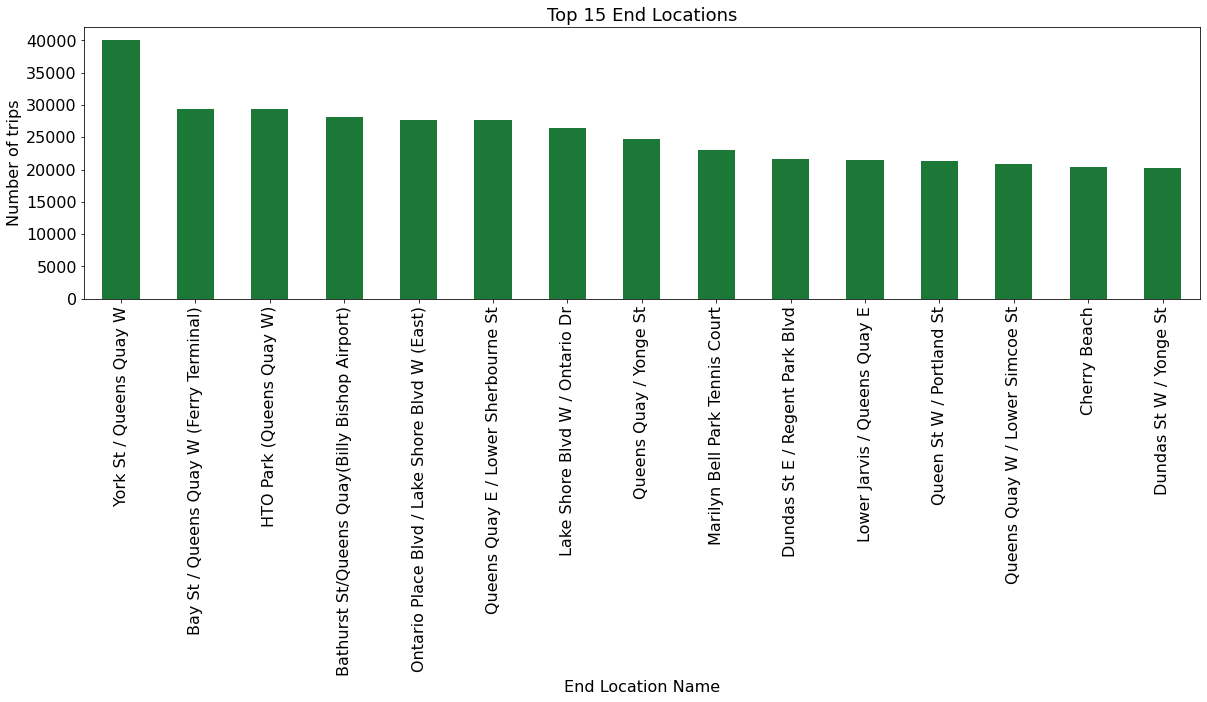

In [38]:

#Plot trip start location
df = d.groupby(["Start Station Name"]).size().to_frame().sort_values([0], ascending = False).head(15).reset_index()
df.columns = ["Start Station Name", 'count']
HistPlot(df, 16, "Number of trips", "Start Location Name", "Top 15 Start Locations",False, 90, kind = "bar", x="Start Station Name", y = "count", color = "#1b7837", figsize = (20,5), legend = False)

#Plot trip end location
df = d.groupby(["End Station Name"]).size().to_frame().sort_values([0], ascending = False).head(15).reset_index()
df.columns = ["End Station Name", 'count']
HistPlot(df, 16, "Number of trips", "End Location Name","Top 15 End Locations", False, 90, kind = "bar", x="End Station Name", y = "count", color = "#1b7837", figsize = (20,5), legend = False)


In [36]:
df_weath = pd.read_csv("en_climate_daily_ON_6158355_2021_P1D.csv", skipinitialspace=True)
print("\nWeather dataframe columns\n",list(df_weath.columns), "\n")

df_weath["Day of Year"] = pd.to_datetime(df_weath['Date/Time'], format = "%Y-%m-%d").dt.dayofyear
d["Day of Year"] = d["Start Time"].dt.dayofyear

#add temperature informaiton to dataframe with map from statcan weather data
d['Mean Temp (°C)'] = d["Day of Year"].map(df_weath.set_index("Day of Year")['Mean Temp (°C)'])

#Some data is missing, drop these rows
d = d[d['Mean Temp (°C)'].notna()]

#Use dictionary of temperature data to add mean temp column to grouped data based on count
temp_dict = df_weath['Mean Temp (°C)'].to_dict()
df = d.groupby(d["Start Time"].dt.dayofyear).size().reset_index()
df.columns = ['Start Time', 'count']
df['Mean Temp (°C)'] = df.index.map(temp_dict)
df = df[df['Mean Temp (°C)'].notna()]
print("Summary of ridership data by day\n",df.describe())


Weather dataframe columns
 ['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID', 'Date/Time', 'Year', 'Month', 'Day', 'Data Quality', 'Max Temp (°C)', 'Max Temp Flag', 'Min Temp (°C)', 'Min Temp Flag', 'Mean Temp (°C)', 'Mean Temp Flag', 'Heat Deg Days (°C)', 'Heat Deg Days Flag', 'Cool Deg Days (°C)', 'Cool Deg Days Flag', 'Total Rain (mm)', 'Total Rain Flag', 'Total Snow (cm)', 'Total Snow Flag', 'Total Precip (mm)', 'Total Precip Flag', 'Snow on Grnd (cm)', 'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)', 'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)', 'Spd of Max Gust Flag'] 

Summary of ridership data by day
        Start Time         count  Mean Temp (°C)
count  359.000000    359.000000      359.000000
mean   181.440111   9721.451253       10.895822
std    105.465746   6051.006334        9.928659
min      1.000000    702.000000      -10.800000
25%     90.500000   4073.000000        2.550000
50%    180.000000   9351.000000       10.500000
75%    271.500000  14336.500

(359, 1) (359,)


Text(0, 0.5, 'Number of riders')

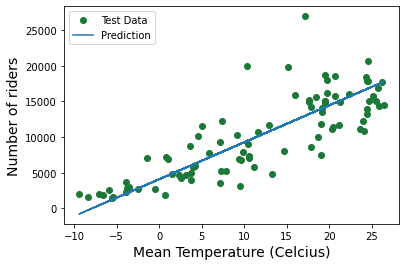

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

feature_cols = ['Mean Temp (°C)']
X = df.loc[:, feature_cols]
y = df.loc[:, "count"]
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True)

#instantiate model
logreg = LinearRegression()

#fit 
logreg.fit(X_train, y_train)

#predict
y_pred = logreg.predict(X_test)

plt.plot(X_test, y_test, 'o', color = "#1b7837", label = "Test Data")
plt.plot(X_test, y_pred, label = "Prediction")
plt.legend()
plt.xlabel("Mean Temperature (Celcius)", size = 14)
plt.ylabel("Number of riders", size = 14)